In [2]:
import pickle
import glob
import re
import os
import pandas as pd
from tqdm import tqdm

In [3]:
CHECKPOINT_DIR = os.path.join('..', 'data', 'checkpoint')
MODEL_DIR = os.path.join('..', 'models')

In [4]:
df = pd.read_parquet('/home/dakoro/Github/ai-text-detection/data/clean_data.parquet', engine='pyarrow')
df = df.iloc[0:60000]

In [5]:
def load_last_checkpoint():
    if not os.path.exists(CHECKPOINT_DIR):
        os.mkdir(CHECKPOINT_DIR)
    
    file_idx = []
    for fp in glob.glob(f'{CHECKPOINT_DIR}/*.pkl'):
        fn = os.path.basename(fp)
        file_idx.append(int(re.findall(r'\d+', fn)[0]))
        
    last_checkpoint_idx = max(file_idx)
    fp = os.path.join(CHECKPOINT_DIR, f'embeddings_{last_checkpoint_idx}.pkl')
    with open(fp, mode='rb') as pklf:
        last_checkpoint_list = pickle.load(pklf)
    return last_checkpoint_list

In [6]:
df['embedding'] = load_last_checkpoint()
df['embedding'] = df['embedding'].apply(lambda emb: emb.mean())

In [7]:
import statistics

def compute_burstiness(text: str) -> float:
    """
    Computes the burstiness of a text, defined as the coefficient of variation
    of sentence lengths (standard deviation / mean).

    A higher score indicates more variation in sentence length, while a lower score
    suggests more uniform sentence lengths.

    Args:
        text: The input string to analyze.

    Returns:
        A float representing the burstiness score. Returns 0.0 for texts with
        fewer than two sentences, as variation cannot be calculated.
    """
    # 1. Handle empty or invalid input
    if not isinstance(text, str) or not text.strip():
        return 0.0

    # 2. Split text into sentences using punctuation as delimiters.
    # This simple regex handles periods, question marks, and exclamation points.
    sentences = [s.strip() for s in re.split(r'[.?!]', text) if s.strip()]

    # 3. Variation requires at least two data points (sentences).
    if len(sentences) < 2:
        return 0.0

    # 4. Calculate the length (in words) of each sentence.
    sentence_lengths = [len(s.split()) for s in sentences]

    # 5. Calculate mean and standard deviation of sentence lengths.
    mean_length = statistics.mean(sentence_lengths)
    stdev_length = statistics.stdev(sentence_lengths)

    # 6. Avoid division by zero if all sentences are empty.
    if mean_length == 0:
        return 0.0

    # 7. Compute burstiness (coefficient of variation).
    burstiness_score = stdev_length / mean_length
    
    return burstiness_score

In [8]:
tqdm.pandas()
df['burstiness'] = df['text'].progress_apply(compute_burstiness)

100%|██████████| 60000/60000 [00:02<00:00, 27449.72it/s]


In [9]:
X = df[['perplexity', 'burstiness', 'embedding']]
y = df['generated']

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import LearningCurveDisplay, learning_curve
clf = AdaBoostClassifier()

In [18]:
import numpy as np
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

param_dist = {
    'n_estimators': sp_randint(50, 500),
    'learning_rate': sp_uniform(0.01, 1.0),
}

In [19]:
from sklearn.model_selection import RandomizedSearchCV
grid = RandomizedSearchCV(clf, param_dist, cv=5, scoring='f1_macro', random_state=42)
grid.fit(X, y)

,estimator,AdaBoostClassifier()
,param_distributions,"{'learning_rate': <scipy.stats....x7d040419dcf0>, 'n_estimators': <scipy.stats....x7d04044363b0>}"
,n_iter,10
,scoring,'f1_macro'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [22]:
train_sizes, train_scores, test_scores = learning_curve(grid.best_estimator_, X, y, scoring='f1_macro', cv=10)

In [23]:
display = LearningCurveDisplay(train_sizes=train_sizes, train_scores=train_scores, test_scores=test_scores, score_name="f1_macro")

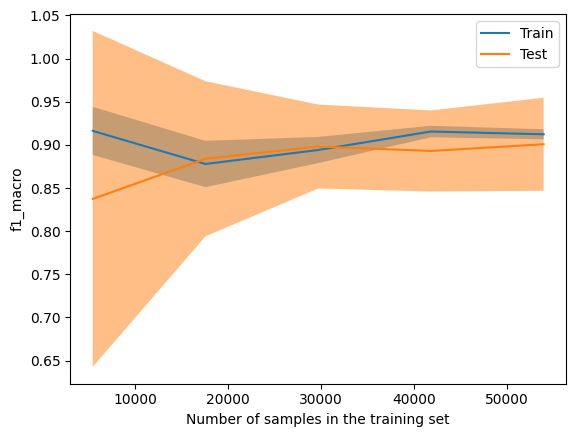

In [24]:
display.plot()

In [25]:
def save_model(filename, model):
    path = os.path.join(MODEL_DIR, filename)
    with open(path, mode='wb') as pklf:
        pickle.dump(model, pklf, pickle.HIGHEST_PROTOCOL)

In [27]:
save_model('ai_detection.pkl', grid.best_estimator_)